In [1]:
import numpy as np
import pandas as pd
from lib_fun import *
from sklearn.covariance import GraphicalLassoCV
from sklearn.decomposition import PCA
from gram_matrix import *
from FOPG import *
from MAVE1 import *
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('carcinom.csv',header=None)
data = data.to_numpy()

In [3]:
Y = data[:,0]
X = data[:,1:]
mean= np.mean(X,axis = 0)
std = np.std(X,axis = 0, ddof =1)

X = (X-mean)/std
n,p = X.shape
d_0 = 2

In [4]:
unique_rows, unique_indices, counts = np.unique(X, axis=0, return_index=True, return_counts=True)

# Get the original indices of duplicate rows
duplicate_indices = np.where(counts > 1)[0]

if duplicate_indices.size > 0:
    print("Duplicate rows found and their indices:")
    for index in duplicate_indices:
        row = unique_rows[index]
        # Get the indices of all occurrences of this row in the original data
        occurrences_indices = np.where(np.all(X == row, axis=1))[0]
        print("Row:", row)
        print("Indices of occurrences:", occurrences_indices)
else:
    print("No duplicate rows found.")

Duplicate rows found and their indices:
Row: [-2.94907422 -0.09768774  0.50622851 ...  0.78947948 -0.72622545
 -0.23229017]
Indices of occurrences: [112 159]


In [5]:
index = pd.read_csv('carcinomindex.csv')
indices = index.iloc[:, 0].values
X = X[:, indices]

In [6]:
Y = Y.reshape(-1, 1)

In [7]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(Y)
Y = encoded_data

In [8]:
ygram = gram_matrix4(Y,1)
beta_fopg =FOPG(X,ygram,d_0)
new_X = X @ beta_fopg

In [9]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

cv = KFold(n_splits=5)
auc_scores = []

for train_index, test_index in cv.split(new_X):
    X_train, X_test = new_X[train_index], new_X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    model = OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=1000))
    model.fit(X_train, Y_train) 

    y_prob = model.predict_proba(X_test)

    auc = roc_auc_score(Y_test.ravel(), np.vstack(y_prob).ravel())
    auc_scores.append(auc)
print(f'Mean AUC (5-fold CV): {np.mean(auc_scores)}')
print(f'Standard Deviation of AUC: {np.std(auc_scores)}')

Mean AUC (5-fold CV): 0.5147351740696279
Standard Deviation of AUC: 0.1553913932079846


c:\Users\ohhit\miniconda3\lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
c:\Users\ohhit\miniconda3\lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 8 is present in all training examples.
  warnings.warn(


In [10]:
ygram2 = gram_matrix4(Y,10)
ygram2 = np.real(sqrtm(ygram2))
init = beta_fopg
beta_dcov, _,_ = MAVE1(X.T,ygram2,init)

new_X = X@beta_dcov

In [11]:
newx1 = X @beta_dcov[:,0]
newx2 = X @beta_dcov[:,1]
class_labels = np.argmax(Y, axis=1)

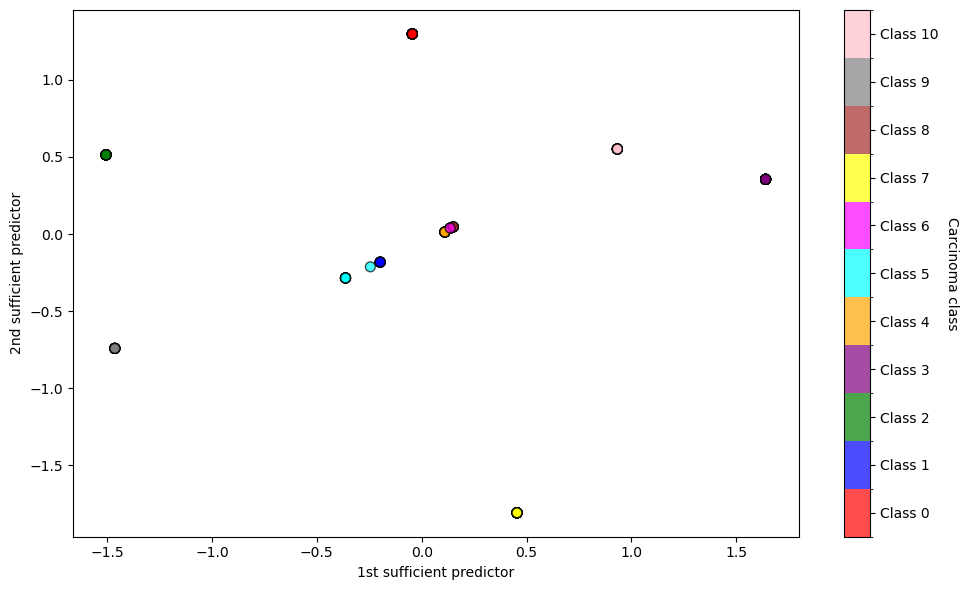

In [12]:
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = ListedColormap(['red', 'blue', 'green', 'purple', 'orange', 'cyan', 
                       'magenta', 'yellow', 'brown', 'gray', 'pink'])
norm = BoundaryNorm(np.arange(-0.5, 11, 1), cmap.N)

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(newx1, newx2, c=class_labels, cmap=cmap, norm=norm, s=50, alpha=0.7, edgecolors='k')

# Add a colorbar with distinct class labels
cbar = plt.colorbar(scatter, ticks=np.arange(11))
cbar.set_label('Carcinoma class', rotation=270, labelpad=15)
cbar.ax.set_yticklabels([f'Class {i}' for i in range(11)])  # Label each class explicitly

# Add axis labels and title
plt.xlabel('1st sufficient predictor')
plt.ylabel('2nd sufficient predictor')


# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('carcinom1.png', dpi=300, bbox_inches='tight')
plt.show()

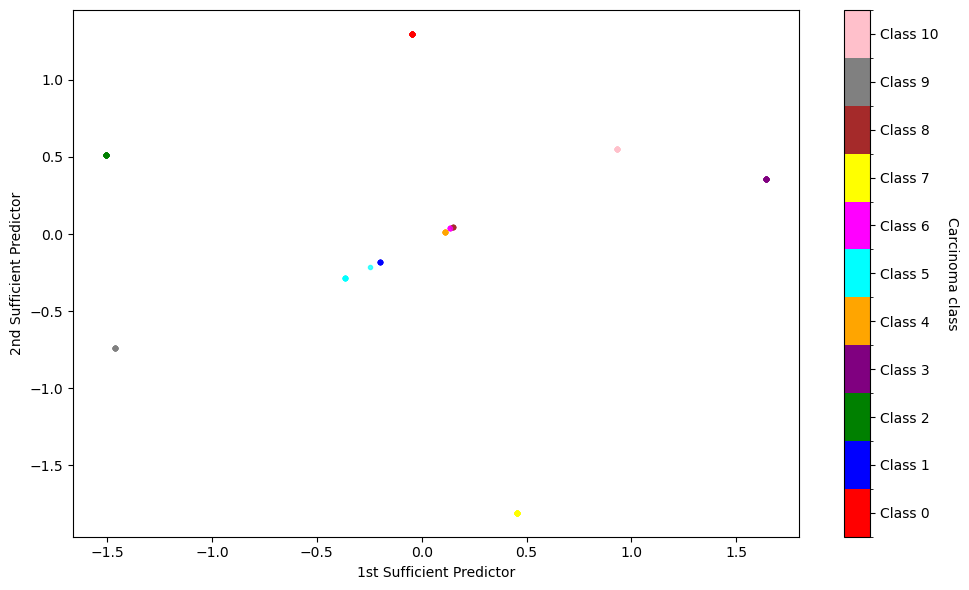

In [13]:
cmap = ListedColormap(['red', 'blue', 'green', 'purple', 'orange', 'cyan', 
                       'magenta', 'yellow', 'brown', 'gray', 'pink'])
norm = BoundaryNorm(np.arange(-0.5, 11, 1), cmap.N)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all points with corresponding class colors
for x1, x2, cls in zip(newx1, newx2, class_labels):
    ax.plot(x1, x2, '.', color=cmap(norm(cls)), alpha=0.7)

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for ScalarMappable

# Add a colorbar explicitly to the axis
cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(11))
cbar.set_label('Carcinoma class', rotation=270, labelpad=15)
cbar.ax.set_yticklabels([f'Class {i}' for i in range(11)])  # Explicit class labels

# Add axis labels and title
ax.set_xlabel('1st Sufficient Predictor')
ax.set_ylabel('2nd Sufficient Predictor')

# Save the plot and display it
plt.tight_layout()
plt.savefig('carcinom2.png', dpi=300, bbox_inches='tight')
plt.show()

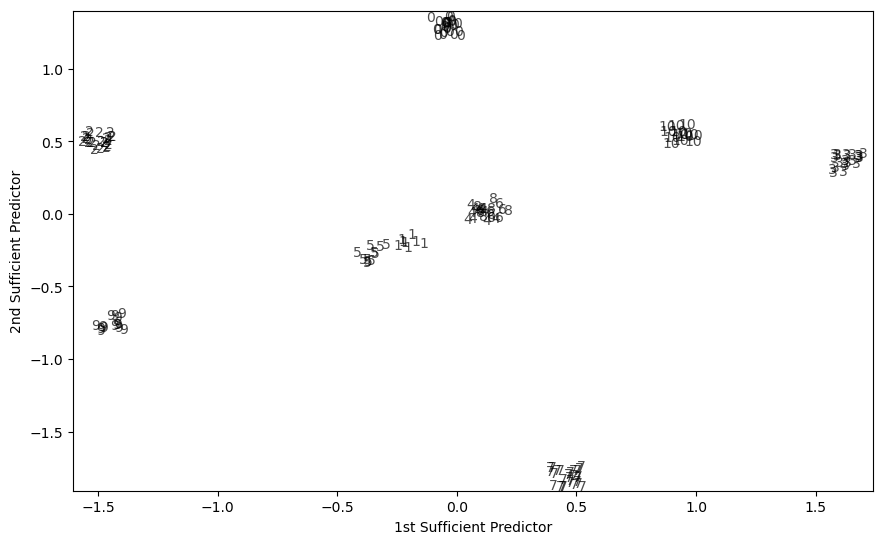

In [61]:
def add_jitter(values, scale=0.001):
    return values + np.random.uniform(-scale, scale, size=len(values))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Apply jitter to x and y values
jittered_x1 = add_jitter(newx1, scale=0.07)
jittered_x2 = add_jitter(newx2, scale=0.07)

# Plot all points with corresponding class labels as text
for x1, x2, cls in zip(jittered_x1, jittered_x2, class_labels):
    ax.text(x1, x2, str(cls), fontsize=10, ha='center', va='center', alpha=0.7)

# Add axis labels and title
ax.set_xlabel('1st Sufficient Predictor')
ax.set_ylabel('2nd Sufficient Predictor')
#ax.set_title('Carcinoma Class Labels on Sufficient Predictors')

# Set axis limits to include the full range of data with some padding
ax.set_xlim(min(newx1) - 0.1, max(newx1) + 0.1)
ax.set_ylim(min(newx2) - 0.1, max(newx2) + 0.1)

# Adjust layout and save the plot
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('carcinom2_numbers_labels.png', dpi=300, bbox_inches='tight')
plt.show()



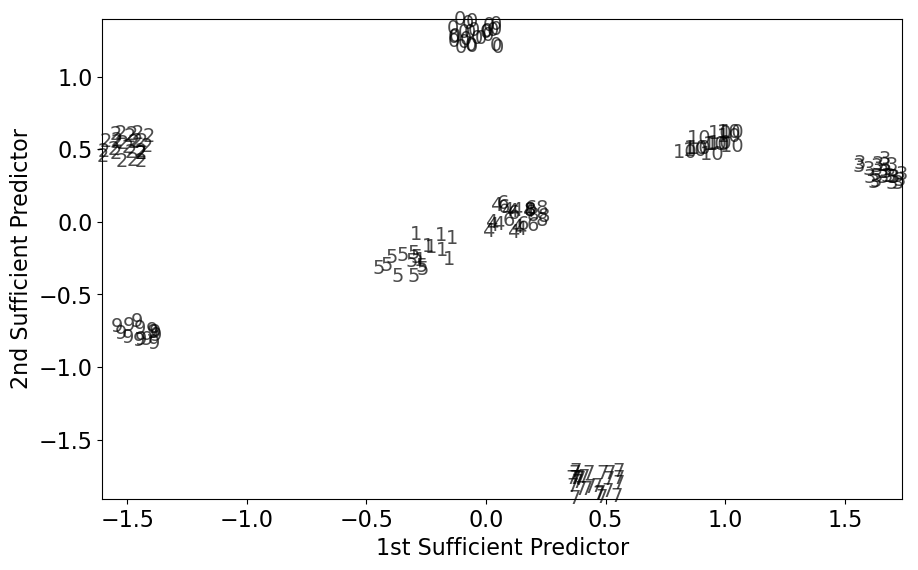

In [72]:
def add_jitter(values, scale=0.001):
    return values + np.random.uniform(-scale, scale, size=len(values))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Apply jitter to x and y values
jittered_x1 = add_jitter(newx1, scale=0.1)
jittered_x2 = add_jitter(newx2, scale=0.1)

# Plot all points with corresponding class labels as text
for x1, x2, cls in zip(jittered_x1, jittered_x2, class_labels):
    ax.text(x1, x2, str(cls), fontsize=14, ha='center', va='center', alpha=0.7)

# Add axis labels and title with larger font sizes
ax.set_xlabel('1st Sufficient Predictor', fontsize=16)
ax.set_ylabel('2nd Sufficient Predictor', fontsize=16)

# Set axis limits to include the full range of data with some padding
ax.set_xlim(min(newx1) - 0.1, max(newx1) + 0.1)
ax.set_ylim(min(newx2) - 0.1, max(newx2) + 0.1)

# Increase the size of tick labels
ax.tick_params(axis='both', which='major', labelsize=16)

# Adjust layout and save the plot
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('carcinom2_numbers_labels.png', dpi=300, bbox_inches='tight')
plt.show()

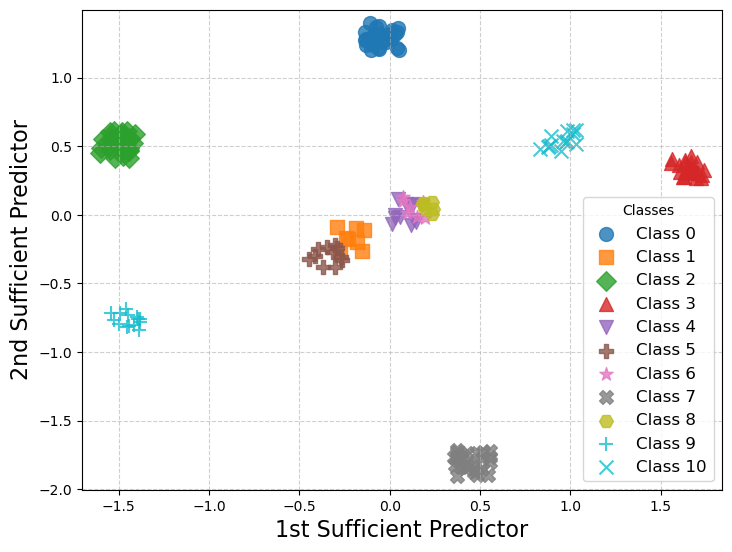

In [73]:

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))  # Specify figure size if needed

# Verify input data
assert len(jittered_x1) == len(jittered_x2) == len(class_labels), "Data lengths must match!"

# Define colors and markers
colors = plt.cm.tab10(range(len(set(class_labels))))  # Colormap for distinct colors
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'H', '+', 'x']  # Marker styles

# Plot each class separately
for cls in set(class_labels):
    cls_indices = [i for i, c in enumerate(class_labels) if c == cls]
    ax.scatter(
        [jittered_x1[i] for i in cls_indices],
        [jittered_x2[i] for i in cls_indices],
        label=f'Class {cls}',
        s=100,  # Marker size
        c=[colors[cls]],  # Color for the class
        marker=markers[cls % len(markers)],  # Cycle through markers
        alpha=0.8  # Transparency for better visualization
    )

# Add axis labels and title
ax.set_xlabel('1st Sufficient Predictor', fontsize=16)
ax.set_ylabel('2nd Sufficient Predictor', fontsize=16)

# Set axis limits with padding
ax.set_xlim(min(jittered_x1) - 0.1, max(jittered_x1) + 0.1)
ax.set_ylim(min(jittered_x2) - 0.1, max(jittered_x2) + 0.1)

# Add legend and grid
ax.legend(fontsize=12, loc='best', title='Classes')
ax.grid(True, linestyle='--', alpha=0.6)

# Adjust layout and save the plot
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('carcinom2_marker_labels.png', dpi=300, bbox_inches='tight')
plt.show()


[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4
  4  4  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  7  7  7  7
  7  7  7  7  7  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10
 10 10 10 10  2 10  4  3  7  6  7  7  3  2  9 10  0  0  2  2  5  2  7  9
  3  3  3  3  3  3  3  3  3  3  9 10  9 10 10  9 10  2  2  2  2  2  2  2
  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  7  7  7  7  7  7  7
  7  7  7  7  7  7]


In [17]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

cv = KFold(n_splits=5)
auc_scores = []

for train_index, test_index in cv.split(new_X):
    X_train, X_test = new_X[train_index], new_X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    model = OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=1000))
    model.fit(X_train, Y_train)  

    y_prob = model.predict_proba(X_test)

    auc = roc_auc_score(Y_test.ravel(), np.vstack(y_prob).ravel())

    auc_scores.append(auc)

print(f'Mean AUC (5-fold CV): {np.mean(auc_scores)}')
print(f'Standard Deviation of AUC: {np.std(auc_scores)}')


Mean AUC (5-fold CV): 0.7957877551020408
Standard Deviation of AUC: 0.17968139214235776


c:\Users\ohhit\miniconda3\lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
c:\Users\ohhit\miniconda3\lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 8 is present in all training examples.
  warnings.warn(


In [18]:
neigh = False
metric = 'Euclidean'
Nb = []
n,p = X.shape 
if not neigh:
    # Neighborhood is unknown
    graphical_lasso_model = GraphicalLassoCV() 
    graphical_lasso_model.fit(X)
    omega = graphical_lasso_model.precision_
        
for j in range(p):
    Ni = np.nonzero(omega[j, :])[0].tolist()
    Nb.append(Ni)

beta_gwire, _ = gwire_cv(X, Y, Nb, metric, d_0, fold=5)

c:\Users\ohhit\miniconda3\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\ohhit\miniconda3\lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [19]:

new_X = X @ beta_gwire 

In [20]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

cv = KFold(n_splits=5)
auc_scores = []

for train_index, test_index in cv.split(new_X):
    X_train, X_test = new_X[train_index], new_X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    model = OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=1000))
    model.fit(X_train, Y_train)  

    y_prob = model.predict_proba(X_test)

    auc = roc_auc_score(Y_test.ravel(), np.vstack(y_prob).ravel())

    auc_scores.append(auc)


print(f'Mean AUC (5-fold CV): {np.mean(auc_scores)}')
print(f'Standard Deviation of AUC: {np.std(auc_scores)}')

Mean AUC (5-fold CV): 0.7137242850081209
Standard Deviation of AUC: 0.2133262794210237


c:\Users\ohhit\miniconda3\lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
c:\Users\ohhit\miniconda3\lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 8 is present in all training examples.
  warnings.warn(
